In [34]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy.spatial.distance import cdist
import time
from tqdm import tqdm
%load_ext autoreload
%autoreload 1
#%aimport __pycache__.lddt.cpython-39
%aimport sautils.encoder_commons
%aimport sautils.common
%aimport torch
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
sid2seq_ss = {}
with open('data/ss.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_ss[sid] = line
            sid = ''
sid2seq_aa = {}
with open('data/aa.fasta') as file:
    sid = ''
    for line in file:
        line = line.lstrip('>').rstrip('\n')
        if not sid:
            sid = line
        else:
            sid2seq_aa[sid] = line
            sid = ''
mat3di = np.load('data/mat3di.npy') * 2.1
blosum = np.load('data/blosum62.npy') * 1.4
with open('data/mat3di.out') as f:
    lines = f.readlines()
i2a = lines[3].split()
def seq2num(q):
    idx = []
    for a in q:
        idx.append(i2a.index(a))
    return np.array(idx)
    
def calcS_np(ss1,ss2 ,aa1, aa2,mat3di, blosum):
    ss1 = seq2num(ss1)
    ss2 = seq2num(ss2)
    aa1 = seq2num(aa1)
    aa2 = seq2num(aa2)
    comb_array_ss = np.array(np.meshgrid(ss1, ss2)).T.reshape(-1, 2)
    comb_array_aa = np.array(np.meshgrid(aa1, aa2)).T.reshape(-1, 2)
    S = (mat3di[comb_array_ss[:,0],comb_array_ss[:,1]].reshape(len(ss1),-1)) + blosum[comb_array_aa[:,0],comb_array_aa[:,1]].reshape(len(aa1),-1)
    return S
def distances(q_points_aln, t_points_aln):
    d_mat = cdist(q_points_aln, t_points_aln)
    return (d_mat)

In [36]:
# Load residue coordinates
coord_dir = 'data/pdb/d*'
if not os.path.exists(coord_dir):
    print('Creating cache first.')
    sautils.encoder_commons.init_coords('data/pdb/d*', coord_dir)
sid2coords = {sid: sautils.encoder_commons.read_coords(coord_dir, sid) for sid in sautils.encoder_commons.list_sids(coord_dir)}

404
196


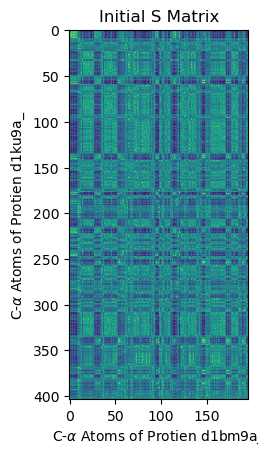

In [37]:
query = 'd1dkza1'
target = 'd2p06a1'
query, target = "d1ufaa2", "d2c1ia1"
#query, target = 'd1nrwa' ,'d2hi0a'
#query, target = "d1bm9a_", "d1ku9a_"
#query, target = "d1ec7a1","d1hjua_"
#query, target = "d2oula_", "d2cb5a_"
#query, target =  "d1u6gc_", "d1ho8a_"

 
qt_swap = False
if len(sid2seq_aa[query]) >= len(sid2seq_aa[target]):
    #query, target = target, query
    qt_swap = True

aa1 = sid2seq_aa[query]
aa2 = sid2seq_aa[target]
ss1 = sid2seq_ss[query]
ss2 = sid2seq_ss[target]
S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
print(len(aa1))
print(len(aa2))
im = plt.imshow(S)
plt.xlabel(r'C-$\alpha$ Atoms of Protien d1bm9a_')
plt.ylabel(r'C-$\alpha$ Atoms of Protien d1ku9a_')
plt.title("Initial S Matrix")
#plt.colorbar(im)
plt.show()
example_alignment = {'query': query,
                     'target': target,
                     'cigar': '10M6I6M1D12M3I2M1I4M2I8M1I6M3I10M9I21M23I2M2D9M7I27M2D48M3D1M1D5M',
                     'qstart': 6,
                     'tstart': 4}
coords1,_ = sid2coords.get(example_alignment['query'])
coords2,_ = sid2coords.get(example_alignment['target'])
coords1 = coords1[:,:3]
coords2 = coords2[:,:3]
d_mat_ij = distances(coords1, coords1)
d_mat_ij[d_mat_ij > 15] = 0
d_mat_kl = distances(coords2, coords2)


In [31]:
fused_model = torch.load('data/distance_model_integrated_1.torch')

w_list = [fused_model[i].weight.detach().numpy() for i in [0, 2, 4, 6, 8]]
bias_list = [fused_model[i].bias.detach().numpy() for i in [0, 2, 4, 6, 8]]


def lol_score_np(d_ij, d_kl, d_seq):    
    x = np.stack(
        [np.log(np.divide(d_ij, d_kl, out=np.zeros_like(d_ij), where = (d_kl != 0))),
         np.log(d_ij, where = (d_ij != 0)),
         np.log(d_kl, where = (d_kl != 0)),
         np.sign(d_seq) * np.log(1 + np.abs(d_seq)),
        ],
        axis=-1)
    # NN
    for w, bias in zip(w_list[:-1], bias_list[:-1]):
        x = ReLU((x @ w.T) + bias)
    x = (x @ w_list[-1].T) + bias_list[-1]  # last layer has no ReLU
    p = sig(x)
    # Probabilities to log odd scores
    score = np.log(p / (1-p)).reshape(-1)
    return score

def ReLU(x):
    return np.where(x > 0, x, 0)
    #return x * (x > 0)
def sig(x):
    return 1/(1 + np.exp(-x)) 

In [32]:
def get_sa(q,t):
    res = []
    for i in range(2):
        res.append(np.load("hyperparameter/start_anchors/"+q+"_"+t+"_"+str(i)+".npy"))
    return res

In [33]:
def get_gaps(A_all):
    lowerBounds_i = (A_all[:,0]+1)[:-1]
    upperBounds_i = (A_all[:,0]-1)[1:]
    lowerBounds_k = (A_all[:,1]+1)[:-1]
    upperBounds_k = (A_all[:,1]-1)[1:]
    mask_i = lowerBounds_i<=upperBounds_i
    mask_k = lowerBounds_k<=upperBounds_k
    mask = np.logical_and(mask_i,  mask_k)
    return np.array([np.sort(np.array([lowerBounds_i[mask],upperBounds_i[mask]+1]).reshape(-1)),
                    np.sort(np.array([lowerBounds_k[mask],upperBounds_k[mask]+1]).reshape(-1))])

In [12]:
def lol_matrix_gap_dist_aprox(A, All_a, gaps,d_mat_ij, d_mat_kl, lol_score_jax, lol_matrix_prep):
    #start = time.time()
    
    
    ti, tk, tidx = lol_matrix_prep_gaps(A, All_a, gaps, d_mat_ij, d_mat_kl)
    #idx = ti > 0 
    idx = np.logical_and(ti > 0, tk > 0)
    #print("time1" ,time.time() - start)
    G_mat = np.zeros_like(ti)
    start = time.time()
    G_mat[idx] += np.nan_to_num(lol_score_jax(ti[idx], tk[idx], tidx[idx]))
    #G_mat = G_mat.at[idx].set(np.nan_to_num(lol_score_jax(ti[idx], tk[idx], tidx[idx])))

    #print("time2", time.time() - start)
    #start = time.time()
    return G_mat.reshape(gaps[0,1]-gaps[0,0],gaps[1,1]-gaps[1,0], -1).sum(axis=2)

In [13]:
def lol_matrix_prep_gaps(A, All_a, gaps,d_mat_ij, d_mat_kl):
    #start = time.time()
    d_ij, d_kl = np.array(d_mat_ij[A[:,0],gaps[0,0]:gaps[0,1]]), np.array(d_mat_kl[A[:,1],gaps[1,0]:gaps[1,1]])

    
    ti = np.repeat(d_ij.T, gaps[1,1]-gaps[1,0], axis = 0).reshape(-1)

    tk = np.repeat(d_kl.T.reshape(-1,1), gaps[0,1]-gaps[0,0], axis = 1).T.reshape(-1)
    #print(A[:,0].reshape(1,-1).shape, d_ij.shape[1] * d_kl.shape[1], np.arange(gaps[0,0],gaps[0,1]).shape, (gaps[1,1]-gaps[1,0]) * A.shape[0],ti.shape,tk.shape)

    tidx = np.repeat(A[:,0].reshape(1,-1), d_ij.shape[1] * d_kl.shape[1], axis = 0).reshape(-1)
    tidx = tidx - np.repeat(np.arange(gaps[0,0],gaps[0,1]), (gaps[1,1]-gaps[1,0]) * A.shape[0])
    #tidx = tidx - np.repeat(np.arange(gaps[0,1]-gaps[0,0]), (gaps[1,1]-gaps[1,0]) * A.shape[0])

    return ti, tk, tidx

In [18]:
startAnchor = get_sa(query,target)

FileNotFoundError: [Errno 2] No such file or directory: 'hyperparameter/start_anchors/d1ufaa2-d2c1ia1-0.npy'

In [13]:
A_new = np.sort(startAnchor[0], axis = 0)
A_all = np.sort(startAnchor[0], axis = 0)

In [14]:
S = np.array(calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum))
S[A_all[:,0], A_all[:,1]] = 1e2
plt.imshow(test_np_save_max(S/100, go=-10/100, ge=-3/100, T=10/100))

NameError: name 'test_np_save_max' is not defined

In [12]:
np.max(test_np(S, go = -1, ge = -.1, T = 10)[2])

7.746102401579063656e+137

/tmp/ipykernel_3930/4088950003.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(test_np(S, go = -1, ge = -.1, T = 10)[2]))


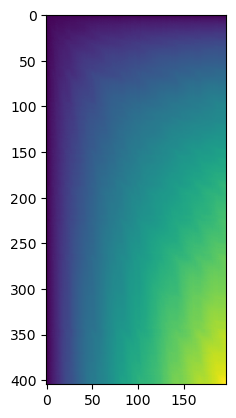

In [11]:
plt.imshow(np.log(test_np(S, go = -1, ge = -.1, T = 10)[2]))

In [19]:
def test_np(S, go = -1, ge = -.1, T = 10):
    #start = time.time()

    #S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
    S_exp = np.exp(S/T, dtype = np.longdouble)
    S_hat = S_exp[::-1,::-1]
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)

    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)
    zm_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)
    ze_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)
    zf_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.longdouble)

    vj = np.exp((np.arange(go, S.shape[1]*ge + go , ge, dtype = np.longdouble))/T)[::-1]
    vj_div = np.exp((np.arange(0,S.shape[1]*ge, ge, dtype = np.longdouble))/T)[::-1]
    
    #print(time.time()-start)
    #start = time.time()
    

    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + 1) *S_exp[i-1,:])
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/vj_div) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
    #print(time.time()-start)
    #start = time.time()

    for i in range(1,S.shape[0]+1):
        zm_hat[i,1:] = ((zm_hat[i-1, :-1] + ze_hat[i-1,:-1] + zf_hat[i-1,:-1] + 1) * S_hat[i-1,:])
        ze_hat[i,1:] = (np.cumsum(zm_hat[i,:-1] * vj)/vj_div) 
        zf_hat[i,1:] = (zm_hat[i-1,1:] * exp_go + zf_hat[i-1,1:] * exp_ge)
    #print(time.time()-start)
    P = ((zm[1:,1:]*(zm_hat[::-1,::-1])[:-1,:-1])/(1 + np.sum(zm))) * np.exp(-S/T)
    return P, zm, zm_hat

In [20]:
def test_np_save_max(S, go=-1, ge=-.1, T=10):
    S_exp = np.array(np.exp(S/T), dtype = np.longdouble)
    S_hat = S_exp[::-1,::-1]
    exp_go = np.exp(go/T)
    exp_ge = np.exp(ge/T)

    zm = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)
    ze = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)
    zf = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)
    zm_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)
    ze_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)
    zf_hat = np.zeros((S.shape[0]+1, S.shape[1]+1), dtype = np.float64)

    vj = np.exp((np.arange(go, S.shape[1]*ge + go , ge, dtype = np.longdouble))/T)[::-1]
    vj_div = np.exp(np.arange(0,S.shape[1]*ge, ge, dtype = np.longdouble)/T)[::-1]
    
    zmax = np.zeros(S.shape[0]+1)
    zmax_hat = np.zeros(S.shape[0]+1)
    current_max = 0
    current_max_hat = 0

    

    for i in range(1,S.shape[0]+1):
        zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + (1/np.exp(current_max))) * S_exp[i-1,:])
        ze[i,1:] = (np.cumsum(zm[i,:-1] * vj)/vj_div) 
        zf[i,1:] = (zm[i-1,1:] * exp_go + zf[i-1,1:] * exp_ge)
        
        z_temp = np.max([zm[i,:],ze[i,:], zf[i,:]])
        zmax[i] = np.log(z_temp)
        current_max += zmax[i]
        zm[i,:],ze[i,:], zf[i,:] = zm[i,:]/z_temp ,ze[i,:]/z_temp, zf[i,:]/z_temp
        

    for i in range(1,S.shape[0]+1):
        zm_hat[i,1:] = ((zm_hat[i-1, :-1] + ze_hat[i-1,:-1] + zf_hat[i-1,:-1] + (1/np.exp(current_max_hat))) * S_hat[i-1,:])
        ze_hat[i,1:] = (np.cumsum(zm_hat[i,:-1] * vj)/vj_div) 
        zf_hat[i,1:] = (zm_hat[i-1,1:] * exp_go + zf_hat[i-1,1:] * exp_ge)
        z_temp_hat = np.max([zm_hat[i,:] ,ze_hat[i,:], zf_hat[i,:]])
        zmax_hat[i] = np.log(z_temp_hat)
        current_max_hat += zmax_hat[i]
        zm_hat[i,:],ze_hat[i,:], zf_hat[i,:] = zm_hat[i,:]/z_temp_hat,ze_hat[i,:]/z_temp_hat, zf_hat[i,:]/z_temp_hat
    
    
    #zm = np.array(np.log(zm+1e-45) + np.cumsum(zmax).reshape(-1,1), dtype = np.longdouble)
    #zm_hat = np.array(np.log(zm_hat+1e-45) + np.cumsum(zmax_hat).reshape(-1,1), dtype = np.longdouble)
    #P = np.exp(zm[1:,1:] + (zm_hat[::-1,::-1])[:-1,:-1], dtype = np.longdouble)/(1 + np.sum(np.exp(zm, dtype = np.longdouble)))* np.exp(-S/T)
    zm = np.multiply(zm, np.exp(np.cumsum(zmax, dtype = np.longdouble)).reshape(-1,1), dtype = np.longdouble)
    zm_hat = np.multiply(zm_hat, np.exp(np.cumsum(zmax_hat, dtype = np.longdouble)).reshape(-1,1), dtype = np.longdouble)
    P = np.array(((zm[1:,1:]*(zm_hat[::-1,::-1])[:-1,:-1])/(1 + np.sum(zm))) * np.exp(-S/T), dtype = np.longdouble)
    return P

In [74]:
def lol_matrix_johannes(A_new, A_all, gaps,d_mat_ij, d_mat_kl, lol_score_jax, lol_matrix_prep):
    G_mat = np.zeros()
    for steps in range(A_new.shape[0]):
        Bi = jnp.argsort(d_mat_ij[i,:])[1:17]
        ti = np.repeat(d_mat_ij[i,Bi], d_mat_kl.shape[0])
        tidx = np.repeat(i - Bi, d_mat_kl.shape[0])
        tk = np.repeat(d_mat_kl[k,:].reshape(1,-1), 16, axis = 0).reshape(-1)
        G_mat[Bi, k] += lol_score_np(ti, tk, tidx).reshape(16,d_mat_kl.shape[0])
        

In [85]:
np.repeat(d_mat_kl[1,:].reshape(1,-1), 16, axis = 0).reshape(-1)

array([ 3.77345611,  0.        ,  3.81543413, ...,  8.6746829 ,
       11.38071075, 14.1420197 ])

In [75]:
lol_matrix_johannes(A_new, A_all, 1 ,d_mat_ij, d_mat_kl, lol_score_np, lol_matrix_prep)

0
1
2
3
4
5
6
7
8
9
10
11
12


In [72]:
A_new = startAnchor[j]
A_all = startAnchor[j]

In [1]:
%%time
lol_matrix_prep = lol_matrix_prep_gaps
for j in range(10):
    num_all = 0
    th = .99
    tempr = 10
    S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
    A_new = startAnchor[j]
    A_all = startAnchor[j]
    print(j)

    for i in (range(0)):
        #start = time.time()
        S[A_all[:,0], A_all[:,1]] = 1e2


        gaps_idn = get_gaps(np.unique(np.concatenate((np.array([0,0]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2))), axis = 0))

        #print(gaps_idn)
        P = np.zeros_like(S)
        for g in range(0, gaps_idn.shape[1], 2):
            S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] += lol_matrix_gap_dist_aproxlol_matrix_gap_dist_aprox(A_new, A_all, gaps_idn[:,g:g+2] ,d_mat_ij, d_mat_kl, lol_score_np, lol_matrix_prep)
            #P[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] = test_np(S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]], go=-10, ge=-0.5, T=8)
        #print("G ",time.time() - start)
        P = test_np(S, go=-10, ge=-1, T=10)

        start = time.time()
        
        P[A_all[:,0], A_all[:,1]] = 0
        #print("P ", time.time() - start)

        m = np.max(P)
        if np.isnan(m):
            print("NaN")
            break

        if m <= 0.4:
            break
            num_all += 2
            if num_all >= 4:
                break
            tempr -= 3
            A_new = A_all[::2]
        else:
            A_new = np.argwhere(P >= np.max([m - 0.15, 0.4]))
            A_all = np.vstack((A_all, A_new))
            A_all = np.sort(A_all, axis = 0)
            num_all -=1

NameError: name 'lol_matrix_prep_gaps' is not defined

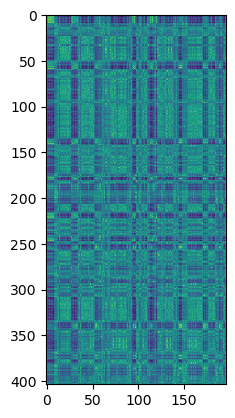

In [87]:
plt.imshow(S)

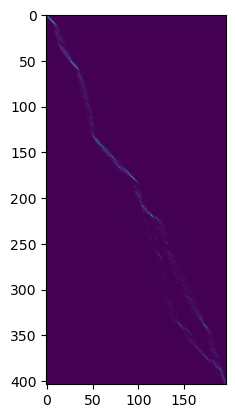

In [100]:
plt.imshow(test_np(S, go=-10, ge=-1, T=10))

In [26]:
%%time
posi = -1
lol_matrix_prep = lol_matrix_prep_gaps

for query, target in zip(querys, targets):
    posi +=1
    startAnchor = get_sa(query,target)
    aa1 = sid2seq_aa[query]
    aa2 = sid2seq_aa[target]
    ss1 = sid2seq_ss[query]
    ss2 = sid2seq_ss[target]
    coords1,_ = sid2coords.get(query)
    coords2,_ = sid2coords.get(target)


    
    coords1 = coords1[:,:3]
    coords2 = coords2[:,:3]
    d_mat_ij = distances(coords1, coords1)
    d_mat_ij[d_mat_ij > 15] = 0
    d_mat_kl = distances(coords2, coords2)


    #startAnchor = calc_startAnchor(aa1, aa2, S, 10)
    print(query, target, posi)
    for j in range(2):
        num_all = 0
        th = .99
        tempr = 1
        S = calcS_np(ss1, ss2, aa1, aa2, mat3di, blosum)
        S = np.zeros_like(S)
        A_new = startAnchor[j]
        A_all = startAnchor[j]
        print(j)

        for i in (range(500)):
            #start = time.time()
            S[A_all[:,0], A_all[:,1]] = 1e2
            
            
            gaps_idn = get_gaps(np.unique(np.concatenate((np.array([-1,-1]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2))), axis = 0))
            
            #print(gaps_idn)
            for g in range(0, gaps_idn.shape[1], 2):
                S[gaps_idn[0,g]:gaps_idn[0,g+1],gaps_idn[1,g]:gaps_idn[1,g+1]] += lol_matrix_gap_dist_aprox(A_new, A_all, gaps_idn[:,g:g+2] ,d_mat_ij, d_mat_kl, lol_score_np, lol_matrix_prep)
            #print("G ",time.time() - start)
            start = time.time()
            P = test_np_save_max(S, go=-13, ge=0, T=1)
            P[A_all[:,0], A_all[:,1]] = 0
            #print("P ", time.time() - start)

            m = np.max(P)
            if np.isnan(m):
                print("NaN")
                break

            if m <= 0.4:
                break
                num_all += 2
                if num_all >= 4:
                    break
                #tempr -= 3
                A_new = A_all[::2]
            else:
                A_new = np.argwhere(P >= np.max([m - 0.1, 0.4]))
                A_all = np.vstack((A_all, A_new))
                A_all = np.sort(A_all, axis = 0)
                num_all -=1
            
        np.save("hyperparameter/data/beginning_para_scores/"+query+"-"+target+"-"+str(j)+".npy", S)

d1f0ya2 d1nyta1 0
0


ZeroDivisionError: division by zero

In [186]:
np.unique(np.array([[1,2],[1,2], [2,3], [4,5]]), axis = 0)

array([[1, 2],
       [2, 3],
       [4, 5]])

In [184]:
np.concatenate((np.array([0,0]).reshape(1,2), A_all, np.array([S.shape[0], S.shape[1]]).reshape(1,2)), axis = 0).shape

(12, 2)

In [180]:
gaps_idn.shape

(2, 4)

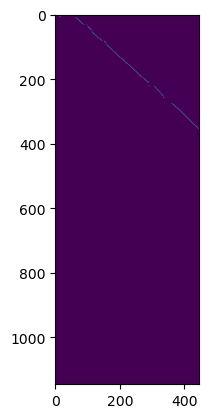

In [137]:
plt.imshow(test_np(S, go=-10, ge=-1, T=10))

In [134]:
np.max(test_np_save_max(S, go=-10, ge=-1, T=10))

2.0


/tmp/ipykernel_3149/2543995512.py:25: RuntimeWarning: overflow encountered in exp
  zm[i,1:] = ((zm[i-1,:-1] + ze[i-1,:-1] + zf[i-1,:-1] + (1/np.exp(current_max))) * S_exp[i-1,:])
/tmp/ipykernel_3149/2543995512.py:36: RuntimeWarning: overflow encountered in exp
  zm_hat[i,1:] = ((zm_hat[i-1, :-1] + ze_hat[i-1,:-1] + zf_hat[i-1,:-1] + (1/np.exp(current_max_hat))) * S_hat[i-1,:])


0.9999999996605432177

In [16]:
alignments = pd.read_csv("hyperparameter/alignments.csv", sep=',')
querys = alignments["query"]
targets = alignments["target"]

In [17]:
alignments

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,query,target,bits,lddt,cigar_fs,qstart_fs,tstart_fs,alnlen,q_scope,t_scope,same_fam,same_sfam,same_fold,qstart_dali,tstart_dali,cigar_dali,dali_rank
0,0,0,31394,d1f0ya2,d1nyta1,82,0.4025,4M1D8M1I12M1D11M8I6M4I6M12I27M2I27M4D10M2I4M,2,15,150,c.2.1.6,c.2.1.7,False,True,True,1,12,4M3D44M24I10M2D4M2I11M1D5M3I28M1D4M1D8M9I4M23I...,61
1,1,1,242793,d2cqqa1,d1rr7a_,33,0.5535,52M,1,43,52,a.4.1.3,a.4.1.14,False,True,True,1,46,22M3I27M,105
2,2,2,265209,d2g5ca2,d1e5qa1,72,0.4330,22M2I18M2I5M6D10M2D23M2I1M1I11M6D6M,4,5,117,c.2.1.6,c.2.1.3,False,True,True,1,2,22M2I30M7D5M1I26M3I7M1I14M3D8M1I5M9I21M7I9M,50
3,3,3,112775,d1osna_,d1odfa_,50,0.2827,15M1D6M2D16M11I3M1D7M2I6M3I4M6I5M6D12M10D5M5D7...,5,27,215,c.37.1.1,c.37.1.6,False,True,True,1,22,4M1D29M3D10M1I4M1I4M13I10M1I5M3D4M1D13M14D24M3...,59
4,4,4,54036,d1hyua4,d3fz9a_,65,0.5050,39M5I7M6D13M2D14M,3,1,86,c.47.1.2,c.47.1.0,False,True,True,3,1,39M5I10M4D9M4D19M1I5M2D5M8D1M,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,495,495,14540,d1cpqa_,d256ba_,95,0.5612,14M3I15M4D8M1I6M1I3M1I3M11I50M,11,4,120,a.24.3.2,a.24.3.1,False,True,True,8,1,20M3I25M2D4M12I55M,8
477,496,496,340716,d3gnja_,d1h75a_,90,0.5284,21M6I12M3D18M5I9M1I7M,25,2,82,c.47.1.0,c.47.1.1,False,True,True,24,1,25M6I19M3D10M5I9M1I4M1I4M2I2M,60
478,497,497,55670,d1i60a_,d1yx1a1,207,0.4871,5M4D29M4I23M1I3M3D2M1D8M8I21M1D7M9I9M3I19M2I13...,2,3,286,c.1.15.4,c.1.15.7,False,True,True,1,2,10M1D4M3D22M1I6M3I16M1I12M4I27M10I4M1I25M2I17M...,7
479,498,498,146136,d1ssqa_,d3bfpa_,37,0.2970,9M2D2M2D1M4I13M6D11M8I19M6D15M6D17M,140,74,121,b.81.1.6,b.81.1.8,False,True,True,4,1,6M18D4M13I11M44I7M9D13M3I10M10I28M2I26M8I47M1I5M,7
